###### Objectives

Drop leakage & ID columns

Handle structural missing values

Handle outliers using capping (winsorization)

Encode categorical variables

Scale numerical features

Build a single sklearn Pipeline

Split data (train/test)


Load Libraries

In [2]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import shap
import joblib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

ModuleNotFoundError: No module named 'utils'

In [2]:
data = pd.read_csv(r"C:\\Users\\JAMES TECH\\Documents\\credit-scoring-mlops\\data\\loan_applicant_data.csv")

In [3]:
data.head()

,CustomerID,LoanID,ApplicantType,Age,EmploymentType,AnnualIncome,MonthlyIncome,LoanType,LoanAmount,LoanTenureMonths,InterestRate,CollateralValue,CreditScore,PastDefaults,NumOpenAccounts,BusinessRevenue,ProfitMargin,BusinessYears,ProbDefault
0,CUST100001,LN200001,Personal,26,Self-employed,709537,59128,Medical,161834,60,11.35,1096384,761,0,0,NaN,NaN,NaN,0.000
1,CUST100002,LN200002,Personal,23,Salaried,507897,42325,Debt Consolidation,600693,24,11.33,687474,688,0,0,NaN,NaN,NaN,0.126
2,CUST100003,LN200003,Personal,57,Salaried,702606,58550,Personal,530371,36,11.30,283442,662,0,1,NaN,NaN,NaN,0.092
3,CUST100004,LN200004,Personal,42,Self-employed,964999,80417,Medical,733422,48,11.39,1319091,788,0,1,NaN,NaN,NaN,0.012
4,CUST100006,LN200006,Business,45,Salaried,1599151,133263,Working Capital,374467,48,17.84,7238008,673,0,2,4092479.0,21.73,12.0,0.000


In [4]:
# view dataset info
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5397 entries, 0 to 5396
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   CustomerID        5397 non-null   object 
 1   LoanID            5397 non-null   object 
 2   ApplicantType     5397 non-null   object 
 3   Age               5397 non-null   int64  
 4   EmploymentType    5397 non-null   object 
 5   AnnualIncome      5397 non-null   int64  
 6   MonthlyIncome     5397 non-null   int64  
 7   LoanType          5397 non-null   object 
 8   LoanAmount        5397 non-null   int64  
 9   LoanTenureMonths  5397 non-null   int64  
 10  InterestRate      5397 non-null   float64
 11  CollateralValue   5397 non-null   int64  
 12  CreditScore       5397 non-null   int64  
 13  PastDefaults      5397 non-null   int64  
 14  NumOpenAccounts   5397 non-null   int64  
 15  BusinessRevenue   1941 non-null   float64
 16  ProfitMargin      1941 non-null   float64


###### Preprocessing

Dropping IDs

In [5]:
data = data.drop(columns=["CustomerID", "LoanID"])

Handling Structural Missing Values

In [6]:
data["IsBusiness"] = (data["ApplicantType"] == "Business").astype(int)

Filling missing values in the business fields with 0

In [7]:
business_cols = ["BusinessRevenue", "ProfitMargin", "BusinessYears"]

data[business_cols] = data[business_cols].fillna(0)

Handling Outliers using Winsorization method

In [8]:
# Defining numerical columns

num_cols = data.select_dtypes(include=["int64", "float64"]).columns
num_cols = num_cols.drop("ProbDefault")


Categorical & Numeric pipelines

In [11]:
cat_cols = ["ApplicantType", "EmploymentType", "LoanType"]

In [14]:
# Numeric pipelines with outliers

num_pipeline = Pipeline(steps=[
    ("winsorize", Winsorizer()),
    ("scaler", StandardScaler())
])

In [16]:
# categorical pipeline

cat_pipeline = Pipeline(steps=[
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

In [17]:
num_pipeline

Pipeline(steps=[('winsorize', Winsorizer()), ('scaler', StandardScaler())])

In [18]:
cat_pipeline

Pipeline(steps=[('encoder', OneHotEncoder(handle_unknown='ignore'))])

In [19]:
# Combining pipelines

preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_pipeline, num_cols),
        ("cat", cat_pipeline, cat_cols)
    ]
)

In [20]:
preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('winsorize', Winsorizer()),
                                                 ('scaler', StandardScaler())]),
                                 Index(['Age', 'AnnualIncome', 'MonthlyIncome', 'LoanAmount',
       'LoanTenureMonths', 'InterestRate', 'CollateralValue', 'CreditScore',
       'PastDefaults', 'NumOpenAccounts', 'BusinessRevenue', 'ProfitMargin',
       'BusinessYears'],
      dtype='object')),
                                ('cat',
                                 Pipeline(steps=[('encoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['ApplicantType', 'EmploymentType',
                                  'LoanType'])])

Train-test-split

In [21]:
X = data.drop(columns=["ProbDefault"])
y = data["ProbDefault"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [22]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4317, 17), (1080, 17), (4317,), (1080,))

Fit & Transform

In [23]:
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

X_train_processed.shape, X_test_processed.shape

((4317, 29), (1080, 29))

###### Model Training

Baseline Models

In [25]:
# Helper Evaluation Functions

def evaluate_model(name, y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"\n{name} Performance:")
    print("RMSE:", rmse)
    print("MAE :", mae)
    print("R2  :", r2)

    return rmse, mae, r2

Linear Regression

In [28]:
lin_model = LinearRegression()
lin_model.fit(X_train_processed, y_train)

lin_preds = lin_model.predict(X_test_processed)

lin_metrics = evaluate_model(
    "Linear Regression",
    y_test,
    lin_preds
)


Linear Regression Performance:
RMSE: 0.11417987280075147
MAE : 0.07116696404600337
R2  : 0.5307203702469254


* Observation

The model explains about 53% variance

The model is okay as a baseline, but not production-grade.

Random Forest Classifier

In [29]:
rf_model = RandomForestRegressor(
    n_estimators=300,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train_processed, y_train)

rf_preds = rf_model.predict(X_test_processed)

rf_metrics = evaluate_model(
    "Random Forest",
    y_test,
    rf_preds
)


Random Forest Performance:
RMSE: 0.04284335639034507
MAE : 0.02090542592592591
R2  : 0.9339276784943558


* Interpretation

Average PD error ≈ 2%

Captures nonlinear risk relationships

Good stability candidate

Variance = 93%

###### Ensemble Models

XGBOOST

In [31]:
xgb_model = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgb_model.fit(X_train_processed, y_train)

xgb_preds = xgb_model.predict(X_test_processed)

xgb_metrics = evaluate_model(
    "XGBoost",
    y_test,
    xgb_preds
)


XGBoost Performance:
RMSE: 0.03920182835236663
MAE : 0.02077025685836715
R2  : 0.9446821568215504


LightGBM

In [32]:
lgb_model = LGBMRegressor(
    n_estimators=500,
    learning_rate=0.05,
    num_leaves=31,
    random_state=42
)

lgb_model.fit(X_train_processed, y_train)

lgb_preds = lgb_model.predict(X_test_processed)

lgb_metrics = evaluate_model(
    "LightGBM",
    y_test,
    lgb_preds
)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.053791 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2177
[LightGBM] [Info] Number of data points in the train set: 4317, number of used features: 29
[LightGBM] [Info] Start training from score 0.099129


C:\Users\JAMES TECH\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(



LightGBM Performance:
RMSE: 0.036852051717000664
MAE : 0.020996827000468787
R2  : 0.9511149642400292


Catboost

In [33]:
cat_model = CatBoostRegressor(
    iterations=500,
    learning_rate=0.05,
    depth=6,
    verbose=0,
    random_state=42
)

cat_model.fit(X_train_processed, y_train)

cat_preds = cat_model.predict(X_test_processed)

cat_metrics = evaluate_model(
    "CatBoost",
    y_test,
    cat_preds
)


CatBoost Performance:
RMSE: 0.03500474394353672
MAE : 0.020453731950362045
R2  : 0.9558931133407641


Final Model Comparism Table

| Model             | RMSE       | MAE         | R²        |
| ----------------- | ---------- | ----------- | --------- |
| Linear Regression | 0.114      | 0.071       | 0.53      |
| Random Forest     | 0.0428     | 0.0209      | 0.934     |
| XGBoost           | 0.0392     | 0.0208      | 0.945     |
| LightGBM          | 0.0369     | 0.0210      | 0.951     |
| CatBoost        | **0.0350** | **0.02045** | **0.956** |


###### Best Model - CATBOOST

Reason:

* Best R²
* Lowest RMSE
* Lowest MAE
* Handles categorical interactions well
* Stable boosting behavior

###### Model Registry And Tracking with clearml

Initializing Task

In [36]:
task = Task.init(
    project_name="Credit Scoring MLOps",
    task_name="PD Model Training - CatBoost Champion"
)

ClearML Task: created new task id=091a8fb50e2e4cdc9a90ea1a26597a98


Could not fetch GPU stats: NVML Shared Library Not Found


ClearML results page: https://app.clear.ml/projects/d548bec3fe3e4bd2b7a741566229c0ae/experiments/091a8fb50e2e4cdc9a90ea1a26597a98/output/log


Logging Metrics

In [37]:
logger = task.get_logger()

logger.report_scalar("RMSE", "CatBoost", cat_metrics[0], iteration=0)
logger.report_scalar("MAE", "CatBoost", cat_metrics[1], iteration=0)
logger.report_scalar("R2", "CatBoost", cat_metrics[2], iteration=0)


ClearML Monitor: GPU monitoring failed getting GPU reading, switching off GPU monitoring


█████████████████████████████████ 100% | 0.09/0.09 MB [00:00<00:00,  4.20s/MB]: 


ClearML Monitor: Could not detect iteration reporting, falling back to iterations as seconds-from-start
ClearML Monitor: Reporting detected, reverting back to iteration based reporting


Saving Model and Preprocessor

In [56]:
joblib.dump(
    preprocessor,
    r"C:\Users\JAMES TECH\Documents\credit-scoring-mlops\models\preprocessor.pkl"
)

cat_model.save_model(
    r"C:\Users\JAMES TECH\Documents\credit-scoring-mlops\models\catboost_model.cbm"
)

Retrying (Retry(total=237, connect=237, read=240, redirect=240, status=240)) after connection broken by 'NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x000001965B132AD0>: Failed to resolve 'api.clear.ml' ([Errno 11001] getaddrinfo failed)")': /v2.23/tasks.get_all
Retrying (Retry(total=237, connect=238, read=239, redirect=240, status=240)) after connection broken by 'NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x000001965B133290>: Failed to resolve 'api.clear.ml' ([Errno 11001] getaddrinfo failed)")': /v2.23/tasks.get_all
Retrying (Retry(total=237, connect=237, read=240, redirect=240, status=240)) after connection broken by 'NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x000001965B131090>: Failed to resolve 'api.clear.ml' ([Errno 11001] getaddrinfo failed)")': /v2.23/events.add_batch
Retrying (Retry(total=236, connect=236, read=240, redirect=240, status=240)) after connection broken by 'NameResolutionError("<urllib3.conn

Uploading Artifacts to ClearML

In [40]:
task.upload_artifact(
    name="preprocessor",
    artifact_object="preprocessor.pkl"
)

task.upload_artifact(
    name="catboost_model",
    artifact_object="catboost_pd_model.pkl"
)

█████████████████████████████████ 100% | 0.01/0.01 MB [00:00<00:00, 34.90s/MB]: 
█████████████████████████████████ 100% | 0.54/0.54 MB [00:04<00:00,  7.48s/MB]: 


True

###### PD  - DEFAULT RISK BANDING

Risk Band Functions

In [42]:
def risk_band(pd_value):
    if pd_value < 0.05:
        return "Low Risk"
    elif pd_value < 0.15:
        return "Medium Risk"
    else:
        return "High Risk"

Applying to Predictions

In [43]:
pd_predictions = cat_model.predict(X_test_processed)

risk_labels = pd.Series(pd_predictions).apply(risk_band)

In [44]:
pd_predictions

array([ 0.09552294, -0.0012087 ,  0.09424216, ...,  0.00554566,
       -0.00049564,  0.05441425])

In [47]:
risk_labels.head()

0    Medium Risk
1       Low Risk
2    Medium Risk
3       Low Risk
4       Low Risk
dtype: object

Adding to Result Table

In [48]:
results_df = pd.DataFrame({
    "Actual_PD": y_test.values,
    "Predicted_PD": pd_predictions,
    "Risk_Band": risk_labels
})

results_df.head()

,Actual_PD,Predicted_PD,Risk_Band
0,0.104,0.095523,Medium Risk
1,0.000,-0.001209,Low Risk
2,0.123,0.094242,Medium Risk
3,0.033,0.028154,Low Risk
4,0.017,0.043889,Low Risk


Risk Distribution

In [49]:
results_df["Risk_Band"].value_counts()

Risk_Band
Low Risk       566
Medium Risk    332
High Risk      182
Name: count, dtype: int64

Risk Visualization

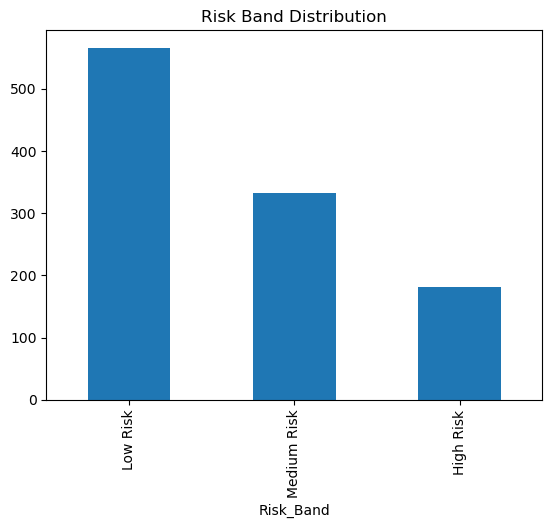

█████████████████████████████████ 100% | 0.11/0.11 MB [00:01<00:00, 11.93s/MB]: 


In [52]:
results_df["Risk_Band"].value_counts().plot(kind="bar")
plt.title("Risk Band Distribution")
plt.show()